# Vertical Regridding
Author: [Jason Boutte](https://github.com/jasonb5)

Date: 01/25/23

Related APIs:

* [xarray.Dataset.regridder.vertical](../generated/xarray.Dataset.regridder.vertical.rst)

The data used in this example can be found through the [Earth System Grid Federation (ESGF) search portal](https://aims2.llnl.gov/search).

## Overview
We"ll cover vertical regridding using `xgcm`.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import xarray as xr
import xcdat
import numpy as np
import gsw_xarray as gsw

import warnings

warnings.filterwarnings("ignore")

## 1. Open the Dataset
We are using xarray"s OPeNDAP support to read a netCDF4 dataset file directly from its source. The data is not loaded over the network until we perform operations on it (e.g., temperature unit adjustment).

More information on the xarray"s OPeNDAP support can be found [here](https://docs.xarray.dev/en/stable/user-guide/io.html#opendap).

In [2]:
urls = [
    "http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Omon/so/gn/v20190308/so_Omon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc",
    "http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Omon/thetao/gn/v20190308/thetao_Omon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc",
]

ds = xr.merge([xcdat.open_dataset(x, chunks={"time": 4}) for x in urls])

# lev coordinate is in cm and bounds is in m, convert lev to m
with xr.set_options(keep_attrs=True):
    ds.lev.load()
    ds["lev"] = ds.lev / 100
    ds.lev.attrs["units"] = "meters"

ds

<xarray.Dataset>
Dimensions:    (lev: 60, nlat: 384, nlon: 320, time: 1980, d2: 2, vertices: 4,
                bnds: 2)
Coordinates:
  * lev        (lev) float64 5.0 15.0 25.0 ... 4.875e+03 5.125e+03 5.375e+03
  * nlat       (nlat) int32 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
  * nlon       (nlon) int32 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
  * time       (time) object 1850-01-15 13:00:00.000007 ... 2014-12-15 12:00:00
    lat        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: d2, vertices, bnds
Data variables:
    time_bnds  (time, d2) object dask.array<chunksize=(4, 2), meta=np.ndarray>
    lat_bnds   (nlat, nlon, vertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lon_bnds   (nlat, nlon, vertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lev_bnds   (lev, d2) float32 dask.array<chunksize=(60, 2), meta=np.ndarray>
    so         (time, lev, nlat, nlon) float32 dask.array<chunksize=(4, 60, 384, 320), meta=np.ndarray>
    nlon_bnds  (nlon, bnds) float64 0.5 1.5 1.5 2.5 ... 318.5 319.5 319.5 320.5
    thetao     (time, lev, nlat, nlon) float32 dask.array<chunksize=(4, 60, 384, 320), meta=np.ndarray>
Attributes: (12/46)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    case_id:                         15
    cesm_casename:                   b.e21.BHIST.f09_g17.CMIP6-historical.001
    contact:                         cesm_cmip6@ucar.edu
    creation_date:                   2019-01-16T23:15:40Z
    ...                              ...
    sub_experiment_id:               none
    branch_time_in_parent:           219000.0
    branch_time_in_child:            674885.0
    branch_method:                   standard
    further_info_url:                https://furtherinfo.es-doc.org/CMIP6.NCA...
    DODS_EXTRA.Unlimited_Dimension:  time

## 2. Create the output grid
Related API: [xcdat.create_grid()](../generated/xcdat.create_grid.rst)

In this example, we will generate a grid with a linear spaced level coordinate.

In [3]:
output_grid = xcdat.create_grid(lev=np.linspace(5, 537, 10))

output_grid

<xarray.Dataset>
Dimensions:   (lev: 10, bnds: 2)
Coordinates:
  * lev       (lev) float64 5.0 64.11 123.2 182.3 ... 359.7 418.8 477.9 537.0
Dimensions without coordinates: bnds
Data variables:
    lev_bnds  (lev, bnds) float64 -24.56 34.56 34.56 93.67 ... 507.4 507.4 566.6

## 3. Regridding using the `linear` method
Related API: [xarray.Dataset.regridder.vertical()](../generated/xarray.Dataset.regridder.vertical.rst)

Here we will regrid the input data to the output grid using the `xgcm` tool and the `linear` method. 

We'll interpolate salinity onto the new vertical grid.

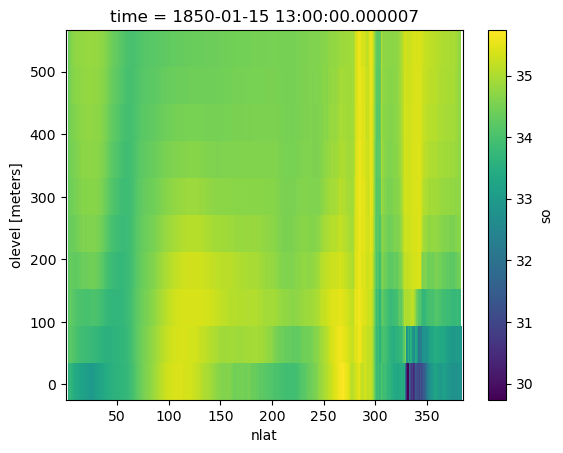

In [4]:
output = ds.regridder.vertical("so", output_grid, tool="xgcm", method="linear")

output.so.isel(time=0).mean(dim="nlon").plot()

## 4. Regridding from depth to density space
Related API: [xarray.Dataset.regridder.vertical()](../generated/xarray.Dataset.regridder.vertical.rst)

Here we will regrid the input data to the output grid using the `xgcm` tool and the `linear` method.

We'll remap salinity into density space.

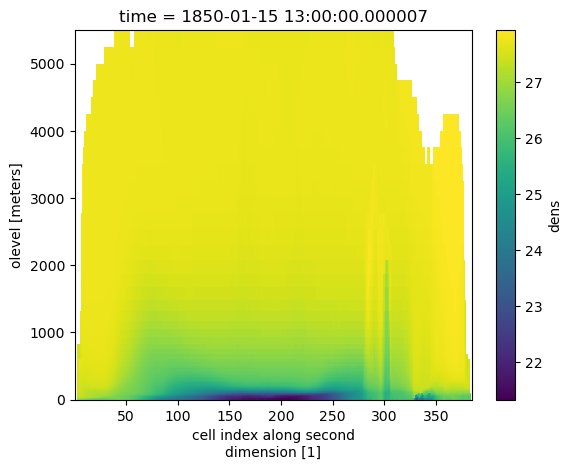

In [5]:
ds["dens"] = gsw.sigma0(ds.so, ds.thetao)

ds.dens.isel(time=0).mean(dim="nlon").plot()

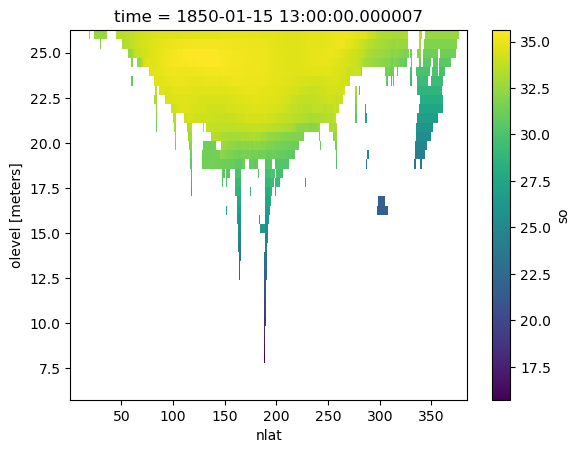

In [6]:
density_grid = xcdat.create_grid(lev=np.linspace(6, 26, 40))

output = ds.regridder.vertical("so", density_grid, tool="xgcm", method="linear", target_data="dens")

output.so.isel(time=0).mean(dim="nlon").plot()

## 5. Regridding using the `conservative` method
Related API: [xarray.Dataset.regridder.vertical()](../generated/xarray.Dataset.regridder.vertical.rst)

Here we will regrid the input data to the output grid using the `xgcm` tool and the `conservative` method.

We"ll transform model levels using conservative regridding. In order to perform the regridding we"ll need two grid positions, the `lev` coordinate is **center** and we"ll create the **outer** points using `cf_xarray`"s `bounds_to_vertices`.

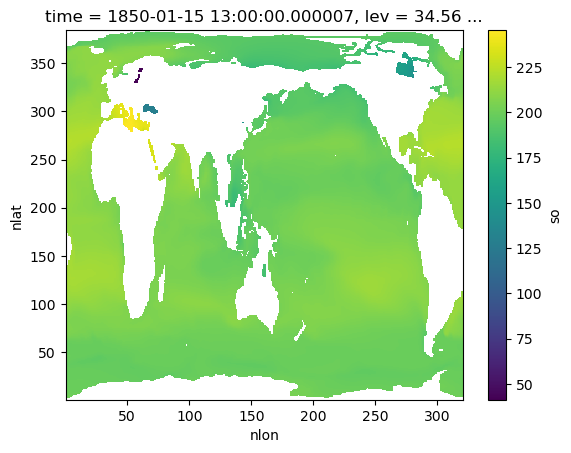

In [7]:
ds_olev = ds.cf.bounds_to_vertices("lev").rename({"lev_vertices": "olev"})

output = ds_olev.regridder.vertical("so", output_grid, tool="xgcm", method="conservative", grid_positions={"center": "lev", "outer": "olev"})

output.so.isel(time=0).sel(lev=0, method="nearest").plot()